## Setup

In [2]:
# Your work will be stored in a folder called `drl_ws21` by default to prevent Colab
# instance timeouts from deleting your edits.
# We do this by mounting your google drive on the virtual machine created in this colab
# session. For this, you will likely need to sign in to your Google account and copy a
# passcode into a field below

import os
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Create paths in your google drive

DRIVE_PATH = '/content/gdrive/My\ Drive/drl_ws21'
DRIVE_PYTHON_PATH = DRIVE_PATH.replace('\\', '')
if not os.path.exists(DRIVE_PYTHON_PATH):
  %mkdir $DRIVE_PATH

# the space in `My Drive` causes some issues,
# make a symlink to avoid this
SYM_PATH = '/content/drl_ws21'
if not os.path.exists(SYM_PATH):
  !ln -s $DRIVE_PATH $SYM_PATH
%cd $SYM_PATH

/content/gdrive/My Drive/drl_ws21


In [4]:
# Install **python** packages

%pip install matplotlib numpy tqdm gym

## Editing Code

All homeworks are self-contained. They can be completed in their respective notebooks.
To edit and re-run code, you can therefore simply edit and restart the code cells below.
There is a timeout of about ~12 hours with Colab while it is active (and less if you close your browser window).
This file should automatically be synced with your Google Drive. We also save all recordings and logs in it by default so that you won't lose your work in the event of an instance timeout.
 However, you will need to re-mount your Google Drive and re-install packages with every new instance.

# Homework 1

In this homework, we will implement basic planning and reinforcement learning algorithms.
We will look at Policy Iteration and Value Iteration, as well as tabular Q-Learning.
The algorithms will be evaluated on a gridworld task from OpenAI gym.

We start by importing all the necessary python modules and defining some helper functions which you do not need to
change.
Still, make sure you are aware of what they do.

## Hint

We will be working with openAI gym DiscreteEnvs which have a property P which is a dictionary of lists, where
```
P[s][a] == [(transition probability, next state, reward, done), ...]
```
for a state $s$ and an action $a$. In FrozenLake, each action has a 33% chance of being executed correctly, and a 33%
chance for adjacent actions, respectively. In non-terminal states, **len(P[s][a]) == 3**  .
This environment is very similar to the one shown in e.g., slide 13 of the Optimal Decision Making lecture.

## Actual code
 This section specifies the actual exercise. It is split into
 * Import statements
 * Logging/Recording utility
 * Runtime arguments
 * Functional code (classes, functions, ...) and explanations

In [5]:
# Imports and utility

import gym
from gym.envs.toy_text.frozen_lake import FrozenLakeEnv
from typing import Tuple
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import time

np.random.seed(0)


np.random.seed(0)

class ProgressBar:
    def __init__(self, num_iterations: int, verbose: bool = True):
        if verbose:  # create a nice little progress bar
            self.scalar_tracker = tqdm.tqdm(total=num_iterations, desc="Scalars", bar_format="{desc}",
                                            position=0, leave=True)
            progress_bar_format = '{desc} {n_fmt:' + str(
                len(str(num_iterations))) + '}/{total_fmt}|{bar}|{elapsed}<{remaining}'
            self.progress_bar = tqdm.tqdm(total=num_iterations, desc='Iteration', bar_format=progress_bar_format,
                                          position=1, leave=True)
        else:
            self.scalar_tracker = None
            self.progress_bar = None

    def __call__(self, **kwargs):
        if self.progress_bar is not None:
            formatted_scalars = {key: "{:.3e}".format(value[-1] if isinstance(value, list) else value)
                                 for key, value in kwargs.items()}
            description = ("Scalars: " + "".join([str(key) + "=" + value + ", "
                                                  for key, value in formatted_scalars.items()]))[:-2]
            self.scalar_tracker.set_description(description)
            self.progress_bar.update(1)

# specify the path to save the recordings of this run to.
data_path = '/content/drl_ws21/exercise_1'
data_path = os.path.join(data_path, time.strftime("%d-%m-%Y_%H-%M"))
if not (os.path.exists(data_path)):
    os.makedirs(data_path)

# this function will automatically save your figure into your google drive folder (if correctly mounted!)
def save_figure(save_name: str) -> None:
    assert save_name is not None, "Need to provide a filename to save to"
    plt.savefig(os.path.join(data_path, save_name + ".png"))

In [6]:
# Initialize Runtime arguments and (hyper-)parameters

class Args:

    # Boilerplate for properly accessing the args
    def __getitem__(self, key):
        return getattr(self, key)

    def __setitem__(self, key, val):
        setattr(self, key, val)

    gamma = 0.99  #@param {type: "number"}
    alpha = 0.1  #@param {type: "number"}

    pi_iters = 100  #@param {type: "integer"}
    vi_iters = 100  #@param {type: "integer"}
    ql_iters = 20000  #@param {type: "integer"}
    t_decay = 10000  #@param {type: "integer"}

args = Args()

In [7]:
# Used functions

class LearningCurvePlotter:
    def __init__(self, env: FrozenLakeEnv, n_eval: int):
        """This class takes a policy and evaluates it on an environment.
        The quality of the policy is recorded in terms of successfully reaching the goal state.

        :param env: FozenLake env
        :param n_eval: How often to evaluate the policy
        """
        self.n_eval = n_eval
        self.env = env
        self.sr = list()

    def eval_policy(self, pi: np.ndarray, render: bool=False) -> np.ndarray:
        """Evaluate a policy on an environment and return success rate

        :param pi: A policy for env
        :param render: Render the policy
        :return: The mean success rate of the given policy
        """

        successes = []

        for ep in range(self.n_eval):
            s = self.env.reset()
            for i in range(100):
                a = int(pi[s])

                s_dash, reward, done, info = self.env.step(a)

                if render:
                    self.env.render()

                if done:#if end state is hitted
                    successes.append(reward)
                    break
                else:
                    s = s_dash
        mean_sr = np.mean(successes)
        self.sr.append(mean_sr)

        return mean_sr

    def plot_lc(self):
        """Plot the learning curve"""
        _, ax = plt.subplots()
        ax.plot(self.sr)
        ax.set_xlabel("Iterations")
        ax.set_ylabel("Success Rate")


def get_reward(transition: list):
    """Transform a reward in the form r(s, a, s') to r(s, a) given a state s and an action a

    r(s, a) = E_p(s'|s,a) [r(s, a, s')] =  sum_s'  p(s'|s, a) * r(s, a, s')

    :param transition: A list of tuples (p(s'|s, a), s', r(s, a, s'), done) containing transition probabilities and rewards
    :return: Reward
    """
    reward = 0
    for tp, _, r, __ in transition: #r(s, a) = E_p(s'|s,a) [r(s, a, s')] =  sum_s'  p(s'|s, a) * r(s, a, s')
        reward += tp * r

    return reward


def plot_value_f(vf: np.ndarray, env: FrozenLakeEnv):
    """Plot the value function for a given environment.
    
    :param vf: A value function
    :param env: An environment
    :return: 
    """
    shape = (env.nrow, env.ncol)

    fig, ax = plt.subplots()
    im = ax.imshow(vf.reshape(shape))
    #
    for i in range(shape[0]):
        for j in range(shape[1]):
            text = ax.text(j, i, env.desc[i, j].decode(),
                           ha="center", va="center", color="w")

## The FrozenLake Environment
First, we have a look at the problem we are solving. The agent controls the movement of a character in a grid world.
Some tiles of the grid are walkable, and others lead to the agent falling into the water.
**Additionally, the movement direction of the agent is uncertain and only partially depends on the chosen direction.**
The agent is rewarded for finding a walkable path to a goal tile.
The episode ends when you reach the goal or fall in a hole.
You receive a reward of 1 if you reach the goal, and zero otherwise.
Actions are encoded as integers 0 = left, 1 = down, 2 = right and 3 = up.
The states are counted from 0 to env.nS.

See https://gym.openai.com/envs/FrozenLake-v0/

Execute the next cell to see what a randomly initialized policy does.

 **Note: This environment computes a reward `r(s,a,s')`, where `s'` is the state that follow from executing
action `a` in state `s`. In the lecture, we mainly focused on a `r(s,a)` representation instead. To
transfer between the two, you can use the provided `get_reward()` method.**

In [8]:
env = gym.make("FrozenLake-v0")

pi_random = np.random.choice(np.arange(env.nA), env.nS)

lc_plotter = LearningCurvePlotter(env, 1)
lc_plotter.eval_policy(pi_random, render=True)



  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG


0.0

## TASK 1: Policy Iteration
The first algorithm we will implement is called Policy Iteration.
It consists of an inner and an outer loop.
The inner loop is called Policy Evaluation and evaluates a given policy on a problem.
For every state, it returns the exact value, i.e. the expected return under the current policy.
The outer loop is called Policy Improvement and, as the name suggests, takes the current policy's value function
and returns an improved version.
In Policy Iteration, we first initialize a policy and value function randomly, and then iteratively run Policy
Evaluation and Policy Improvement until convergence.

The **pseudocode** looks as follows:

---
- **Init** Initialize $V_{(0)}^{\pi_0}(s)=0$ for all $s$, $\pi_0 \leftarrow$ uniform, $k = 0$

- **Repeat**  For $i=1, 2, \dots$

    - `Policy Evaluation`

        - **Init** Initialize $V_{(0)}^{\pi_{i}}(s) = V_{(k)}^{\pi_{i-1}}(s)$ (i.e. initialize the value function of the new policy with the converged value function of the old policy)

        - **Repeat** For $k=1, 2, \dots$

        $V_{(k)}^{\pi_{i}}(s) = \sum_a \pi(a \mid s)  \Big( r(s,a) + \gamma \sum_{s'} P(s' \mid s,a) \, V_{(k - 1)}^{\pi_{i}}(s') \Big)$

        - **Until convergence**

    - `Policy Improvement`

         \begin{align}
      \pi_{(i+1)}(a \mid s)  = \begin{cases}1, & \text{if } a =  \underset{a'}{\arg \max} \Big( r(s,a') + \gamma \sum_{s'} P(s' \mid s,a') V^{\pi_i}(s')\Big)\\0 & \text{else}\end{cases}
    \end{align}

- **Until convergence**

---

### Task 1.1 (6 Points)
In this first task you have to implement the missing code snippets (marked as *TODO*) of the policy iteration class. The **pseudocode** shown above might be helpful. 
1. Implement the missing code snippet of the **policy_evaluation** function below. (3 points) 
2. Implement the missing code snippet of the **policy_improvement** function below. (3 points)


After you have finished implementing the corresponding functions, execute the code cell *Run Policy Iteration*. This code cell will automatically save your value function plot and the learning curve plot into your mounted drive folder. You will need to submit these figures in rogether with the notebook as a zip file.  

In [59]:
#@title Default title text
class PolicyIteration:
    def __init__(self, env: FrozenLakeEnv, gamma: float):
        """A class for performing Policy Iteration

        :param env:
        :param gamma:
        """
        self.env = env
        self.gamma = gamma

        self.n_states = env.nS
        self.n_actions = env.nA

        self.lc_plotter = LearningCurvePlotter(env, 100)

    def policy_evaluation(self, pi_prob: np.ndarray, v=None) -> np.ndarray:
        """Perform the Policy Evaluation step given a policy pi and an environment.

        :param pi_prob: Action probabilities
        :param v: Initial value function (optional)
        :return: value function of the provided policy
        """

        if v is None:
            # Initialize value function for policy evaluation
            v = np.zeros(shape=self.n_states)
        for pe_iter in range(10000):
            # save current estimate
            v_prev = np.copy(v)
            env.compute_reward
            ## TODO ##
            # your code here
            # hint: you will need to iterate over states and actions here
            for i in range(self.n_states):
                v_iter = 0
                for j in range(self.n_actions):
                    K = 0 #initialize the recursive gain
                    for k in range(len(self.env.P[i][j])): #iterate s_dash to compute the recursive gain
                        tp = self.env.P[i][j][k][0]
                        s_d = self.env.P[i][j][k][1]
                        K += tp*v_prev[s_d]
                    r = get_reward(self.env.P[i][j])
                    v_iter += pi_prob[i][j]*(r+self.gamma*K)
                v[i] = v_iter

            # run policy evaluation until convergence
            if np.allclose(v, v_prev):
                break
        return v

    def policy_improvement(self, v:np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """Perform the Policy Improvement step given a value function.

        :param v: Value function of a policy
        :return: New policy and distribution over action probabilities
        """

        # initialize policy
        pi = np.zeros(shape=self.n_states, dtype=int)  # contains the actual actions
        pi_prob = np.zeros(shape=(self.n_states, self.n_actions))  # contains the action probabilities for each state

        ## TODO ##
        # your code here
        # hint: This again requires you to iterate over states and actions in some way.
        # You can use np.argmax() to get the index of the biggest value in an array.

        # b = 0
        # c = 0
        # for i in range(3):
        #     b += i
        #     c =+ i 
        # print("b=",b)
        # print("c=",c)

        action_vallist = np.zeros(shape=(self.n_states, self.n_actions))
        for i in range(self.n_states):
            for j in range(self.n_actions):
                r = get_reward(self.env.P[i][j])
                K = 0 #initialize the recursive gain
                for k in range(len(self.env.P[i][j])):#iterate s_dash to compute the recursive gain
                    tp = self.env.P[i][j][k][0]
                    s_d = self.env.P[i][j][k][1]
                    K += tp*v[s_d]
                action_vallist[i][j] = r+self.gamma*K
            pi[i] = np.argmax(action_vallist[i])
            pi_prob[i][pi[i]] = 1 
            
        return pi, pi_prob

    def policy_iteration(self, n_iter: int) -> (np.array, np.array):
        """Perform Policy Iteration given a DiscreteEnv environment and a discount factor gamma for n_iter iterations

        :param env: An openAI Gym DiscreteEnv object
        :param gamma: Discount factor
        :param n_iter: Number of PI iterations
        :return: Final value function and optimal policy

        """

        v = np.zeros(shape=self.n_states)
        pi = np.zeros(shape=self.n_states)  # contains the actual actions
        pi_prob = np.ones(shape=(self.n_states, self.n_actions)) / self.n_actions  # contains the action probabilities for each state, initialised as an uniform distribution
        
        print("Iteration |  max|V-Vprev|  | # chg actions | V[0]    ")
        print("----------+----------------+---------------+---------")
        for pi_iter in range(n_iter):
            pi_old = np.copy(pi)
            v_old = np.copy(v)

            # run policy evaluation
            v_init = np.copy(v_old)
            v = self.policy_evaluation(pi_prob, v_init)

            # run policy improvement
            pi, pi_prob = self.policy_improvement(v)

            # evaluate policy success rate
            self.lc_plotter.eval_policy(pi)

            max_diff = np.abs(v - v_old).max()

            n_chg_actions = 0 if pi_old is None else (pi != pi_old).sum()
            print("{:4d}      | {:12.5f}   |   {:4d}        | {:8.3f}".format(pi_iter, max_diff, n_chg_actions, v[0]))

            if max_diff < 1e-5:
                break

        return v, pi

        

#### Run Policy Iteration 

Iteration |  max|V-Vprev|  | # chg actions | V[0]    
----------+----------------+---------------+---------
   0      |      0.43358   |      6        |    0.012
   1      |      0.56397   |      1        |    0.532
   2      |      0.08993   |      0        |    0.542
   3      |      0.00000   |      0        |    0.542


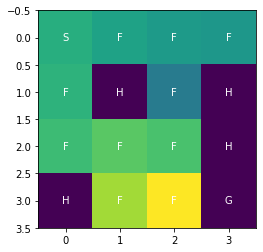

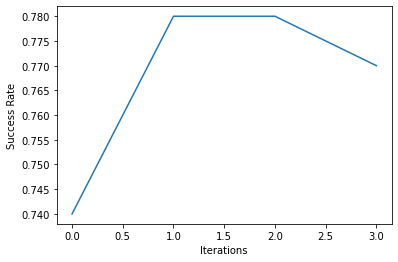

In [61]:
# Run Policy Iteration  

env = gym.make("FrozenLake-v0")

p_iteration = PolicyIteration(env, args['gamma'])
v_p, pi_p = p_iteration.policy_iteration(args['pi_iters'])

plot_value_f(v_p, env)
save_figure("vf_pi")
p_iteration.lc_plotter.plot_lc()
save_figure("lc_pi")

## **TASK 2: Value Iteration**
Next, we will have a look at Value Iteration.
It is very similar to Policy Iteration and only executes one step of policy evaluation.
The **pseudocode** looks as follows

---
- **Init** Initialize $V_{(0)}^\ast(s)=0$, for all $s$

- **Repeat**  For $i=1, 2, \dots$

    $V^\ast_{(i)}(s) = \underset{a}{\max}  \Big( r(s,a) + \gamma \sum_{s'} P(s' \mid s,a) \, V^\ast_{(i-1)}(s') \Big)$, for all $s$

- **Until convergence**

---


### Task 2.1 (4 Points)
In this task you have to implement the missing code snippets (marked as *TODO*) of the Value iteration calss. The **psuedocode** shown above might be helpful.
1. Implement the missing code snippet of the **value_iteration** function below 

After you have finished implementing the corresponding functions, execute the code cell *Run Value Iteration*. This code cell will automatically save your value function plot and the learning curve plot into your mounted drive folder. You will need to submit these figures together with the notebook as a zip file. 

In [13]:
class ValueIteration:
    def __init__(self, env: FrozenLakeEnv, gamma: float):
        """A class for performing Value Iteration

        :param env: A FrozenLakeEnv environment
        :param gamma: Discount factor
        """
        self.env = env
        self.gamma = gamma

        self.n_states = env.nS
        self.n_actions = env.nA

        self.lc_plotter = LearningCurvePlotter(env, 100)

    def value_iteration(self, n_iter: int) -> (list, list):
        """Perform Value Iteration given a DiscreteEnv environment and a discount factor gamma for n_iter iterations.

        :param n_iter: Number of VI iterations
        :return: A tuple (final value_function, optimal policy)
        """

        v = np.zeros(shape=self.n_states)
        pi = np.zeros(shape=self.n_states)

        print("Iteration |  max|V-Vprev|  | # chg actions | V[0]    ")
        print("----------+----------------+---------------+---------")
        
        #value iteration
        for it in range(0, n_iter):
            pi_old = np.copy(pi)
            v_old = np.copy(v)

            ## TODO ##
            # your code here
            # hint: Here, you will need to fill the new policy pi and value function v for all states s.
            # I.e., you need to update pi[s], v[s] for all s.
            action_vallist = np.zeros(shape=(self.n_states,self.n_actions))
            for i in range(self.n_states):
                for j in range(self.n_actions):
                    K = 0
                    for k in range(len(self.env.P[i][j])):
                        s_d = self.env.P[i][j][k][1]
                        tp = self.env.P[i][j][k][0]
                        K += tp*v_old[s_d]
                    r = get_reward(self.env.P[i][j])
                    action_vallist[i][j] = r+self.gamma*K 
                v[i] = np.max(action_vallist[i])
            
            #one step look ahead to find optimal policy
            Q = np.zeros(shape=(self.n_states,self.n_actions))
            for i in range(self.n_states):
                for j in range(self.n_actions):
                    K = 0
                    for k in range(len(self.env.P[i][j])):
                        tp = self.env.P[i][j][k][0]
                        s_d = self.env.P[i][j][k][1]
                        K += tp*v[s_d]
                    r = get_reward(self.env.P[i][j])
                    Q[i][j] = r+self.gamma*K
                pi[i] = np.argmax(Q[i])
            
            # Evaluate policy success rate
            self.lc_plotter.eval_policy(pi)

            max_diff = np.abs(v - v_old).max()
            n_chg_actions = 0 if pi_old is None else (pi != pi_old).sum()
            print("{:4d}      | {:12.5f}   |   {:4d}        | {:8.3f}".format(it, max_diff, n_chg_actions, v[0]))

            if max_diff < 1e-5:
                # assume convergence if the difference is small enough
                break

        return v, pi

#### Run Value Iteration

Iteration |  max|V-Vprev|  | # chg actions | V[0]    
----------+----------------+---------------+---------
   0      |      0.33333   |      2        |    0.000
   1      |      0.11000   |      1        |    0.000
   2      |      0.07260   |      2        |    0.000
   3      |      0.07187   |      1        |    0.000
   4      |      0.05139   |      4        |    0.000
   5      |      0.04696   |      2        |    0.004
   6      |      0.03659   |      1        |    0.010
   7      |      0.03253   |      1        |    0.018
   8      |      0.02714   |      0        |    0.027
   9      |      0.02355   |      1        |    0.038
  10      |      0.02091   |      1        |    0.050
  11      |      0.01847   |      0        |    0.063
  12      |      0.01718   |      0        |    0.076
  13      |      0.01621   |      1        |    0.090
  14      |      0.01522   |      0        |    0.104
  15      |      0.01462   |      0        |    0.118
  16      |      0.01429   |

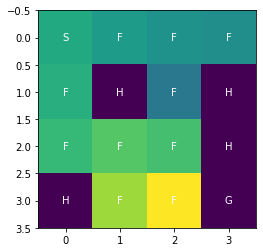

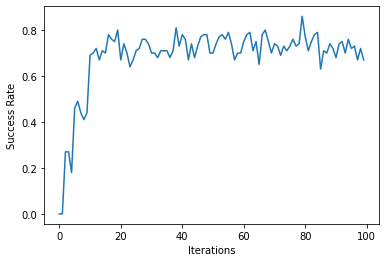

In [14]:
# Run Value Iteration 

env = gym.make("FrozenLake-v0")

v_iteration = ValueIteration(env, args['gamma'])
v_v, pi_v = v_iteration.value_iteration(args['vi_iters'])

plot_value_f(v_v, env)
save_figure("vf_vi")
v_iteration.lc_plotter.plot_lc()
save_figure("lc_vi")

## **TASK 3: Q-Learning**
In Policy Iteration and Value Iteration, we assume to have knowledge about the problem's underlying dynamics and reward
function. These properties are usually not available in practice.
Instead, we need to solve the problem by exploiting what we have learned so far and exploring previously unseen situations.
An algorithm to solve a problem in this fashion is Q-Learning. The **pseudocode** is given as

---
- **Init** Initialize $Q_{(0)}(s, a)=0$, for all $s$ and $a$

- **Repeat**  For $i=1, 2, \dots$
    - sample an action $a$ using the exploration strategy and get the next state $s'$ and associated reward $r$
    - If s' is terminal:
        - $\delta = r(s, a) - Q_{(i-1)}(s, a)$
        - Reset environment and set $s$ to new initial state
    - Else:
        - $\delta = r(s, a) + \gamma \underset{a'}{\max} Q_{(i-1)}(s', a') - Q_{(i-1)}(s, a)$
        - Set $s \leftarrow s'$

    $Q_{(i)}(s, a) = Q_{(i-1)}(s, a) + \alpha \delta$

- **Until convergence**

---

### Task 3.1 (5 Points)
We will implement the missing cod snippet (marked as *TODO*) of the QLearning class. The **pseudoclass** shown above might be helpful.

1. Finish the Q-Learning inner loop in the learn function, by implementing the TD-Error and the Q-Learning update rule 

After you have finished implementing the corresponding functions, execute the code cell *Run QLearning*. This code cell will automatically save your value function plot and the learning curve plot into your mounted drive folder. You will need to submit these figures together with the notebook as a zip file. 

In [63]:
class QLearning:
    def __init__(self, env: FrozenLakeEnv, gamma: float, alpha: float, t_decay: int = 10000):
        """A class for tabular Q-Learning with epsilon-greedy exploration.
         The policy is defined implicitly by the Q-function attribute.

        :param env: A FrozenLakeEnv environment
        :param gamma: Discount factor
        :param alpha: Learning rate
        """
        self.env = env
        self.gamma = gamma
        self.alpha = alpha
        self.t_decay = t_decay

        self.n_states = env.nS
        self.n_actions = env.nA
        self.q = np.zeros(shape=(self.n_states, self.n_actions))
        self.t = 0

        self.lc_plotter = LearningCurvePlotter(env, 100)

    def get_greedy_action(self, s: int) -> int:
        """Return the greedy action given a state. Can be used to evaluate the policy after learning.

        :param s: A state
        :return: An action
        """
        return int(np.argmax(self.q[s, :]))

    def sample_action(self, s: int) -> int:
        """Sample an action based on the epsilon greedy strategy with time decaying exploration.

        :param s: A state
        :return: An action
        """
        if np.random.random() < np.minimum(0.99, self.t / self.t_decay):
            action = self.get_greedy_action(s)

        else:
            action = np.random.randint(0, self.n_actions)

        self.t += 1
        return int(action)

    def learn(self, n_iter):
        """Perform n_iter iterations of Q-Learning

        :param n_iter: Number of learning iterations
        :return: The learned Value function and policy
        """
        s = self.env.reset()

        for i in range(n_iter):
            a = self.sample_action(s)

            s_dash, reward, done, info = self.env.step(a)

            ## TODO ##
            # your code here
            # hint: use an if-else to handle terminal states (done==True) differently from non-terminal ones.

            if done:
                delta = reward - self.q[s][a]
                s_dash = self.env.reset()
            else:
                delta = reward + self.gamma*np.max(self.q[s_dash])-self.q[s][a]
            self.q[s][a] = self.q[s][a]+self.alpha*delta
            s = s_dash

            # evaluate policy success rate
            if i % 100 == 0:
                self.lc_plotter.eval_policy(np.argmax(self.q, axis=1))

        v = np.max(self.q, axis=1)
        pi = np.argmax(self.q, axis=1)

        return v, pi


#### Run QLearning

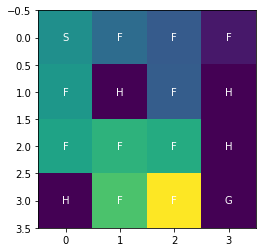

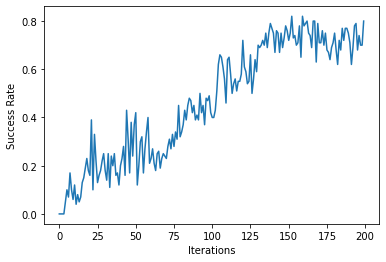

In [66]:
# Run QLearning

env = gym.make("FrozenLake-v0")
# If you are interested in this, you may also try the 8x8 version and adjust the parameters for Q-Learning
# This is *not* part of the exercise however. Your figure should still show the 4x4 version
# for the 8x8 version, run the following code instead:
# env = gym.make('FrozenLake8x8-v0')

np.random.seed(0)  # reset the seed in case of multiple cell executions
q_learning = QLearning(env, args['gamma'], args['alpha'], args['t_decay'])
v_q, pi_q = q_learning.learn(args['ql_iters'])

plot_value_f(v_q, env)
save_figure("vf_q")
q_learning.lc_plotter.plot_lc()
save_figure("lc_q")